In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# LSTM library
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Importing the CSV file
apple_training_complete = pd.read_csv("./AAPL.csv")

# Filter only for the "Open" collumn on the csv file
apple_training_processed = apple_training_complete.iloc[:, 1:2].values

# Applying normalization
scaler = MinMaxScaler(feature_range = (0, 1))
apple_training_scaled = scaler.fit_transform(apple_training_processed)

# Convert training to the right shape
N_RECORDS = len(apple_training_processed)
PAST_DAYS = 60
features_set = []
labels = []
for i in range(PAST_DAYS, N_RECORDS):
    features_set.append(apple_training_scaled[i-PAST_DAYS:i, 0]) # previous N records
    labels.append(apple_training_scaled[i, 0])

# Converting to numpy arrays
features_set, labels = np.array(features_set), np.array(labels)

# Converting to the LSTM format where the dimensions are:
# - number of records (1260)
# - number of time steps (past days) (60)
# - number of indicators/features. In our case, we want only the "Open" column, so it's 1
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

# Model initialization
model = Sequential()

# Adding LSTM layer
# a funcao "add" literalmente adiciona um novo layer, que no nosso caso, sera um LSTM

# The fist LSTM parameter is the number of neurons on the node
# The second one is basically true, because we'll add more layers to the model
# The last one is a shape indicating the number of time steps and the number of indicators
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))

# Adding Dropout layer (avoids over-fitting)
model.add(Dropout(0.2))

# Adding three more LSTM and Dropout layers
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Adding Dense Layer (ending layer...?)
# 1 unit beause we want to predict
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


2022-04-13 16:44:03.431261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-13 16:44:03.431307: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-13 16:44:06.044839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-13 16:44:06.044861: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-13 16:44:06.044878: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (itstar-MacBookPro): /proc/driver/nvidia/version does not exist
2022-04-13 16:44:06.045074: I tensorflow/core/platform/cpu_

Training the model

In [2]:
# Training the model
# epochs --> number of iteractions probably
model.fit(features_set, labels, epochs = 12, batch_size = 32)

Epoch 1/12
7/7 [==============================] - 15s 244ms/step - loss: 0.2092
Epoch 2/12
7/7 [==============================] - 2s 271ms/step - loss: 0.0679
Epoch 3/12
7/7 [==============================] - 2s 216ms/step - loss: 0.0569
Epoch 4/12
7/7 [==============================] - 1s 189ms/step - loss: 0.0290
Epoch 5/12
7/7 [==============================] - 1s 154ms/step - loss: 0.0265
Epoch 6/12
7/7 [==============================] - 1s 195ms/step - loss: 0.0257
Epoch 7/12
7/7 [==============================] - 1s 213ms/step - loss: 0.0223
Epoch 8/12
7/7 [==============================] - 1s 175ms/step - loss: 0.0234
Epoch 9/12
7/7 [==============================] - 2s 356ms/step - loss: 0.0244
Epoch 10/12
7/7 [==============================] - 2s 219ms/step - loss: 0.0224
Epoch 11/12
7/7 [==============================] - 2s 303ms/step - loss: 0.0224
Epoch 12/12
7/7 [==============================] - 4s 413ms/step - loss: 0.0203


Testing our LSTM

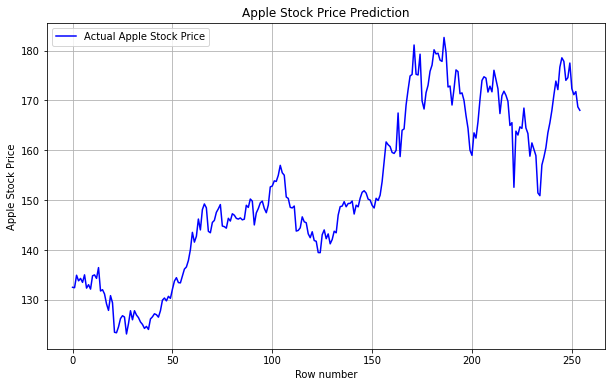

In [3]:
# Importing the data
apple_testing_complete = pd.read_csv("./AAPL.csv")
apple_testing_processed = apple_testing_complete.iloc[:, 1:2].values

plt.figure(figsize=(10,6))
plt.plot(apple_testing_processed, color='blue', label='Actual Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Row number')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.grid()
plt.show()

# Converting Test Data to Right Format
For each day of January 2018, we want our feature set to contain the opening stock prices for the previous 60 days. For the 1st of January, we need the stock prices for the previous 60 days. To do so, we need to concatenate our training data and test data before preprocessing. Execute the following script to do so:

In [4]:
apple_total = pd.concat((apple_training_complete['Open'], apple_testing_complete['Open']), axis=0)

Now let's prepare our test inputs. The input for each day should contain the opening stock prices for the previous 60 days. That means we need opening stock prices for the 20 **(wtf, why 20?)** test days for the month of January 2018 and the 60 stock prices from the last 60 days for the training set. Execute the following script to fetch those 80 values.

In [5]:
test_inputs = apple_total[len(apple_total) - len(apple_testing_complete) - 60:].values

As we did for the training set, we need to scale our test data. Execute the following script:

In [6]:
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

We scaled our data, now let's prepare our final test input set that will contain previous 60 stock prices for the month of January. Execute the following script:

In [7]:
test_features = []
for i in range(PAST_DAYS, len(apple_testing_processed)): 
    # 80 aparentemente para fazer o 20 cursed que tem la em cima... 
    # but i didn't understand that pretty well
    test_features.append(test_inputs[i-PAST_DAYS:i, 0])

Finally, we need to convert our data into the three-dimensional format which can be used as input to the LSTM. Execute the following script:

In [8]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

# Making Predictions
Now is the time to see the magic. We preprocessed our test data and now we can use it to make predictions. To do so, we simply need to call the predict method on the model that we trained. Execute the following script:

In [9]:
predictions = model.predict(test_features)

Since we scaled our data, the predictions made by the LSTM are also scaled. We need to reverse the scaled prediction back to their actual values. To do so, we can use the ìnverse_transform method of the scaler object we created during training. Take a look at the following script:

In [10]:
predictions = scaler.inverse_transform(predictions) # reverse the scale

Finally, let's see how well did our algorithm predicted the future stock prices. Execute the following script:

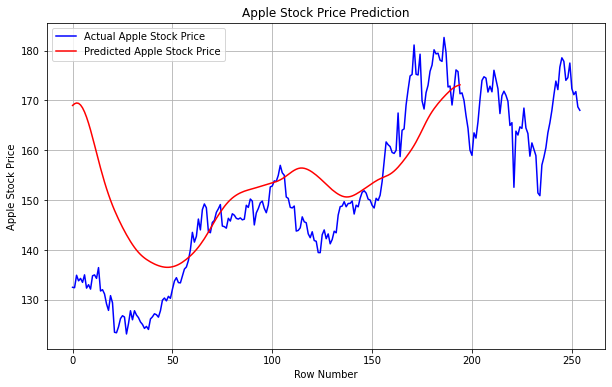

len(predictions) = 195
len(apple_testing_processed) = 255


In [11]:
plt.figure(figsize=(10,6))
plt.plot(apple_testing_processed, color='blue', label='Actual Apple Stock Price')
plt.plot(predictions , color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Row Number')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.grid()
plt.show()
print(f"{len(predictions) = }")
print(f"{len(apple_testing_processed) = }")